In [1]:
from mxnet import nd

In [4]:
x = nd.arange(12)
x


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
<NDArray 12 @cpu(0)>

In [3]:
import numpy as np
from mxnet import nd

P = np.ones((2,3))
D=nd.array(P)
D


[[1. 1. 1.]
 [1. 1. 1.]]
<NDArray 2x3 @cpu(0)>

In [4]:
D.asnumpy()

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [5]:
from mxnet import autograd,nd

x=nd.arange(4).reshape((4,1))

x


[[0.]
 [1.]
 [2.]
 [3.]]
<NDArray 4x1 @cpu(0)>

In [6]:
x.attach_grad()

In [8]:
with autograd.record():
    y = 2 * nd.dot(x.T,x)

In [9]:
y.backward()

In [10]:
x.grad


[[ 0.]
 [ 4.]
 [ 8.]
 [12.]]
<NDArray 4x1 @cpu(0)>

In [11]:
print(autograd.is_training())
with autograd.record():
    print(autograd.is_training())

False
True


In [12]:
def f(a):
    b = a *2
    while b.norm().asscalar() < 1000:
        b = b*2
    if b.sum().asscalar() > 0:
        c = b
    else:
        c = 100*b
    return c

In [13]:
a = nd.random.normal(shape=1)
a.attach_grad()
with autograd.record():
    c =f(a)
c.backward()

In [14]:
a.grad == c/a


[1.]
<NDArray 1 @cpu(0)>

In [16]:
print(dir(nd.random))

['NDArray', '_Null', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_internal', '_random_helper', 'current_context', 'exponential', 'exponential_like', 'gamma', 'gamma_like', 'generalized_negative_binomial', 'generalized_negative_binomial_like', 'multinomial', 'negative_binomial', 'negative_binomial_like', 'normal', 'normal_like', 'numeric_types', 'poisson', 'poisson_like', 'randint', 'randn', 'shuffle', 'uniform', 'uniform_like']


In [17]:
nd.ones_like?

In [21]:
from mxnet import nd
from time import time

a = nd.ones(shape=1000)
b = nd.ones(shape=1000)

In [23]:
start = time()
c = nd.zeros(shape=1000)
for i in range(1000):
    c[i] = a[i]+b[i]
time() - start

0.12322807312011719

In [24]:
start = time()
d = a+b
time() - start

0.0002701282501220703

线性回归的实现

In [25]:
%matplotlib inline
from IPython import display 
from matplotlib import pyplot as plt
from mxnet import autograd,nd
import random

In [28]:
num_inputs=2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2
features = nd.random.normal(scale=1,shape=(num_examples,num_inputs))
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
labels +=nd.random.normal(scale=0.01,shape=labels.shape)

In [29]:
features[0],labels[0]

(
 [1.7974477  0.19594947]
 <NDArray 2 @cpu(0)>, 
 [7.1156087]
 <NDArray 1 @cpu(0)>)

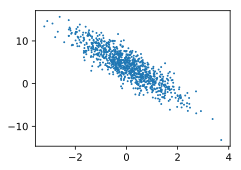

In [31]:
def use_svg_display():
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:,1].asnumpy(),labels.asnumpy(),1);

In [34]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        j = nd.array(indices[i:min(i+batch_size,num_examples)])
        yield features.take(j),labels.take(j)

In [35]:
batch_size = 10

for X,y in data_iter(batch_size,features,labels):
    print(X,y)
    break


[[ 0.29881802 -1.9982076 ]
 [-0.5851423  -0.4044047 ]
 [-0.33194333 -1.3807931 ]
 [ 1.3060192  -0.6950609 ]
 [ 0.59492165 -1.258278  ]
 [-2.3271089  -1.3389597 ]
 [ 1.7974477   0.19594947]
 [-0.87756306 -0.3624442 ]
 [ 0.40506515 -1.9947851 ]
 [ 1.2439611  -1.4614984 ]]
<NDArray 10x2 @cpu(0)> 
[11.589913   4.4140253  8.2205515  9.173782   9.663859   4.0918865
  7.1156087  3.660865  11.786679  11.662479 ]
<NDArray 10 @cpu(0)>


In [39]:
w = nd.random.normal(scale=0.01,shape=(num_inputs,1))
b = nd.zeros(shape=(1,))

In [40]:
w.attach_grad()
b.attach_grad()

In [41]:
def linreg(X,w,b):
    return nd.dot(X,w) + b


In [42]:
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [43]:
def sgd(params,lr,batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

In [47]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        with autograd.record():
            l = loss(net(X,w,b),y)
        l.backward()
        sgd([w,b],lr,batch_size)
    train_l = loss(net(features,w,b),labels)
    print('epoch %d,loss %f'%(epoch + 1,train_l.mean().asnumpy()))

epoch 1,loss 0.000052
epoch 2,loss 0.000051
epoch 3,loss 0.000051


In [48]:
true_w,w

([2, -3.4], 
 [[ 2.000073 ]
  [-3.4002545]]
 <NDArray 2x1 @cpu(0)>)

In [49]:
true_b,b

(4.2, 
 [4.1994634]
 <NDArray 1 @cpu(0)>)

线性回归的简介实现

In [54]:
from mxnet import autograd,nd

num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2
features = nd.random.normal(scale=1,shape=(num_examples,num_inputs))
labels = true_w[0] * features[:,0] + true_w[1]*features[:,1]+true_b
labels += nd.random.normal(scale=0.01,shape=labels.shape)

In [58]:
from mxnet.gluon import data as gdata

batch_size  = 10
dataset = gdata.ArrayDataset(features,labels)
data_iter = gdata.DataLoader(dataset,batch_size,shuffle=True)

In [59]:
for X,y in data_iter:
    print(X,y)
    break


[[-1.1375728e-01 -1.4455683e+00]
 [ 1.1721278e-03 -2.5828764e-01]
 [ 2.0151109e-02 -1.3578221e+00]
 [-6.6100311e-01  5.6645888e-01]
 [-4.6847045e-01  3.5317874e-01]
 [ 8.9934123e-01 -3.2651913e-01]
 [ 4.7790268e-03 -5.2753156e-01]
 [-1.0657686e+00  9.7285700e-01]
 [-8.3587863e-02  7.3293573e-01]
 [-6.7483656e-02  1.0828042e+00]]
<NDArray 10x2 @cpu(0)> 
[ 8.889717    5.0918617   8.853211    0.96939296  2.0601194   7.093152
  6.018242   -1.2270066   1.5506736   0.36838958]
<NDArray 10 @cpu(0)>


In [61]:
from mxnet.gluon import nn

net = nn.Sequential()
net.add(nn.Dense(1))

In [62]:
from mxnet import init

net.initialize(init.Normal(sigma=0.01))

In [63]:
from mxnet.gluon import loss as gloss

loss = gloss.L2Loss()

In [64]:
from mxnet import gluon

trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.03})

In [66]:
num_epochs = 3
for epoch in range(1,num_epochs + 1):
    for X,y in data_iter:
        with autograd.record():
            l = loss(net(X),y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net(features),labels)
    print('epoch %d,loss:%f'%(epoch,l.mean().asnumpy()))

epoch 1,loss:0.032611
epoch 2,loss:0.000126
epoch 3,loss:0.000054


In [67]:
dense = net[0]
true_w,dense.weight.data()

([2, -3.4], 
 [[ 1.9993345 -3.4002857]]
 <NDArray 1x2 @cpu(0)>)

In [69]:
true_b,dense.bias.data()

(4.2, 
 [4.1992736]
 <NDArray 1 @cpu(0)>)